FASE 1 : Comprensión del negocio 

World of warcraft es un MMORPG en el cual los jugadores pueden caracterizarse por razas y a la vez por clases. Puede personalizar su personaje para pelear contra otros jugadores o para realizar misiones del juego y subir de nivel de personaje o de honor con las distintas zonas. Cada una de estas zonas están diseñadas para conllevar distintos tipos de jugadores, desde los más novatos hasta los más avanzados en el juego. Este juego tiene muchos factores con los cuales se pueden generar diferentes análisis, ya sea, sobre la popularidad de las zonas, la media de jugadores por nivel, control de las zonas a lo largo del tiempo, cómo han cambiado las preferencias de zonas y actividades de los jugadores con diferentes versiones del juego, etc. 

Ahora, nuestro equipo, con el DataSet entregado decidió hacer un análisis exhaustivo el cual se centre en el ámbito de las zonas, más específicamente, el equipo responderá la interrogante de : ¿Existen zonas donde el nivel de los jugadores es más homogéneo en comparación con otras zonas?, ¿Qué tipo de zonas (por ejemplo, mazmorras, ciudades, áreas PvP) son más populares?, ¿Hay zonas altamente disputadas entre facciones y cómo afecta esto al comportamiento de los jugadores?, ¿Los jugadores de niveles más bajos evitan zonas controladas por facciones opuestas o de nivel alto? . Descubrir si hay zonas con una población de niveles más homogénea nos puede dar pistas sobre las preferencias de los jugadores y cómo eligen moverse por el mundo del juego. Esto puede estar influenciado por el diseño de las zonas, el tipo de contenido disponible y las recompensas que se pueden obtener. En esta primera fase de nuestro análisis CRISP-DM, vamos a sumergirnos en los datos para detectar cómo se distribuyen los niveles de los jugadores en diferentes zonas. Este análisis nos ayudará a encontrar patrones y a entender cómo la uniformidad de niveles varía de una zona a otra, lo cual puede ser crucial para futuras decisiones de diseño y ajuste dentro del juego.

En este trabajo nos basaremos en el modelo analitico de CRISP-DM para nuestro proceso de Machine Learning. Este modelo tiene como ventaja que es flexible, facil de comprender y adaptable a la gran mayoria de proyectos. CRISP-DM tiene como formación una cantidad de 6 fases, estas son: 
**1) Comprensión del negocio:**  Definir claramente el contexto y los objetivos del negocio.
**2) Comprensión de los datos:** Explorar, describir y analizar los datos de los DataSets para identificar problemas de calidad o patrones importantes.
**3) Preparación de los datos:** Limpiar, transformar y seleccionar los datos relevantes para el análisis.
**4) Modelado:** Aplicar algoritmos y técnicas de minería de datos (como árboles de decisión, regresión, etc.) para construir modelos que resuelvan el problema de negocio.
**5) Evaluación:** Verificar si los modelos creados son útiles y cumplen con los objetivos del negocio, ajustando si es necesario.
**6) Despliegue:** Implementar el modelo en un entorno real, ya sea para automatizar decisiones, generar informes o cualquier otra aplicación del negocio requerido.

FASE 2 : Comprensión de los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error

In [3]:
zones = pd.read_csv('../data/01_raw/zones.csv')
wowah_data = pd.read_csv('../data/01_raw/wowah_data.csv')
locations = pd.read_csv('../data/01_raw/locations.csv')
wowah_data2 = pd.read_csv('../data/01_raw/wowah_data.csv')


Debido a problemas con la escrituras del dataframe fuente de wowah_data vamos a ejecutar una linea con la cuál eliminas los espacios.

In [4]:
wowah_data.columns = wowah_data.columns.str.strip()
wowah_data2.columns = wowah_data2.columns.str.strip()

Para comenzar con el análisis exploratorio, es esencial identificar y comprender la información contenida en cada uno de los datasets que vamos a utilizar. A continuación, se presenta un resumen de los tres principales datasets involucrados en nuestro estudio.

In [213]:
zones.head(8)

,Zone_Name,Continent,Area,Zone,Subzone,Type,Size,Controlled,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
0,Durotar,Kalimdor,Central Kalimdor,Durotar,NaN,Zone,NaN,Horde,1,1.0,10.0,1.0,10.0
1,The Barrens,Kalimdor,Central Kalimdor,The Barrens,NaN,Zone,NaN,Contested,1,10.0,35.0,10.0,35.0
2,Silverpine Forest,Eastern Kingdoms,Lordaeron,Silverpine Forest,NaN,Zone,NaN,Horde,1,10.0,20.0,10.0,20.0
3,Stonetalon Mountains,Kalimdor,Central Kalimdor,Stonetalon Mountains,NaN,Zone,NaN,Contested,1,25.0,30.0,25.0,30.0
4,Thunder Bluff,Kalimdor,Central Kalimdor,Thunder Bluff,NaN,City,NaN,Horde,1,1.0,100.0,1.0,100.0
5,Dustwallow Marsh,Kalimdor,Central Kalimdor,Dustwallow Marsh,NaN,Zone,NaN,Contested,1,35.0,40.0,35.0,40.0
6,Orgrimmar,Kalimdor,Central Kalimdor,Durotar,Orgrimmar,City,NaN,Horde,1,1.0,100.0,1.0,100.0
7,Undercity,Eastern Kingdoms,Lordaeron,Tirisfal Glades,Undercity,City,NaN,Horde,1,1.0,100.0,1.0,100.0


In [214]:
wowah_data.head(8)

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09
5,2289,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09
6,61239,68,Orc,Hunter,Blade's Edge Mountains,243,01/01/08 00:02:14
7,59772,69,Orc,Warrior,Shadowmoon Valley,35,01/01/08 00:02:14


In [215]:
locations.head(8)

,Map_ID,Location_Type,Location_Name,Game_Version
0,0,Continent,Eastern Kingdoms,WoW
1,1,Continent,Kalimdor,WoW
2,530,Continent,Outlands,TBC
3,571,Continent,Northrend,WLK
4,646,Continent,Deepholm,CAT
5,732,Continent,Tol Barad,CAT
6,870,Continent,Pandaria,MoP
7,1064,Continent,Mogu Island Daily Area (Isle of Thunder),MoP


Al analizar estos tres datasets, buscamos identificar patrones en la distribución de los niveles de los jugadores a través de diferentes zonas, entender cómo las características de las zonas afectan esta distribución y explorar cómo los mapas y sus versiones juegan un papel en la experiencia del juego. Este enfoque nos permitirá obtener una visión integral de cómo los jugadores interactúan con el mundo de World of Warcraft y cómo se pueden ajustar las zonas y los mapas para mejorar el juego.

Vamos a describir los datos para proporcionar un análisis detallado que va más allá de los estadísticos básicos obtenidos con la función describe(). Esto no solo presenta las medidas de tendencia central y dispersión, sino que también ayuda a interpretar cómo estos valores se relacionan con el negocio. Al hacerlo, se pueden identificar patrones y tendencias que son esenciales para la toma de decisiones informadas, mejorar estrategias de juego y optimizar la experiencia del usuario. Esta comprensión más profunda de los datos es crucial para un análisis efectivo y para obtener información valiosa que respalde el desarrollo.

es útil saber qué tipo de datos tenemos en cada uno de los datasets. Esto nos ayuda a entender cómo podemos trabajar con la información. A continuacion mostraremos los diferente tipos de datos de cada uno de los datasets:

In [216]:
zones.describe()

,Size,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
count,68.000000,160.000000,159.000000,159.000000,158.000000,158.000000
mean,11.544118,22.975000,39.981132,61.918239,40.518987,61.974684
std,10.935952,29.272511,28.165980,27.350276,28.128622,26.861036
min,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,5.000000,1.000000,10.000000,42.000000,10.000000,40.750000
50%,5.000000,1.000000,45.000000,70.000000,46.000000,70.000000
75%,16.250000,57.250000,67.000000,80.000000,68.000000,80.000000
max,40.000000,80.000000,80.000000,100.000000,80.000000,100.000000


In [217]:
zones.dtypes
description = zones.describe()
for column in description.columns:
    print(f"Análisis de {column}:")
    
    mean_value = description.loc['mean', column]
    print(f" - Media (Promedio): {mean_value:.2f} ")
    
    median_value = zones[column].median()
    print(f" - Mediana: {median_value:.2f} ")
    
    q1 = description.loc['25%', column]
    q3 = description.loc['75%', column]
    iqr = q3 - q1
    print(f" - IQR (Rango Intercuartílico): {iqr:.2f} ")
    
    std_dev = description.loc['std', column]
    print(f" - Desviación estándar: {std_dev:.2f} ")
    
    min_value = description.loc['min', column]
    max_value = description.loc['max', column]
    print(f" - Mínimo: {min_value:.2f}, Máximo: {max_value:.2f} ")


Análisis de Size:
 - Media (Promedio): 11.54 
 - Mediana: 5.00 
 - IQR (Rango Intercuartílico): 11.25 
 - Desviación estándar: 10.94 
 - Mínimo: 5.00, Máximo: 40.00 
Análisis de Min_req_level:
 - Media (Promedio): 22.98 
 - Mediana: 1.00 
 - IQR (Rango Intercuartílico): 56.25 
 - Desviación estándar: 29.27 
 - Mínimo: 1.00, Máximo: 80.00 
Análisis de Min_rec_level:
 - Media (Promedio): 39.98 
 - Mediana: 45.00 
 - IQR (Rango Intercuartílico): 57.00 
 - Desviación estándar: 28.17 
 - Mínimo: 0.00, Máximo: 80.00 
Análisis de Max_rec_level:
 - Media (Promedio): 61.92 
 - Mediana: 70.00 
 - IQR (Rango Intercuartílico): 38.00 
 - Desviación estándar: 27.35 
 - Mínimo: 0.00, Máximo: 100.00 
Análisis de Min_bot_level:
 - Media (Promedio): 40.52 
 - Mediana: 46.00 
 - IQR (Rango Intercuartílico): 58.00 
 - Desviación estándar: 28.13 
 - Mínimo: 1.00, Máximo: 80.00 
Análisis de Max_bot_level:
 - Media (Promedio): 61.97 
 - Mediana: 70.00 
 - IQR (Rango Intercuartílico): 39.25 
 - Desviación est

La mayoría de las zonas tienen tamaños pequeños, con un promedio de 11.54 y una mediana de 5.0. Hay una amplia variación en el tamaño (máximo 40). En cuanto a los niveles, el nivel mínimo requerido promedio es 22.98, pero la mayoría de las zonas tienen un nivel mínimo de 1, lo que indica que muchas están accesibles desde el inicio. El nivel recomendado mínimo promedio es 39.98, y el máximo es 61.92, lo que sugiere que las zonas están diseñadas para jugadores de nivel medio-alto. En cuanto a los bots, el nivel mínimo promedio es 40.52, con un máximo de 61.97, lo que indica que los bots son, en su mayoría, de niveles similares a los recomendados para jugadores.

In [218]:
wowah_data.describe()

,char,level,guild
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.722180e+04,6.056243e+01,1.218761e+02
std,2.172658e+04,1.784720e+01,9.460111e+01
min,7.000000e+00,1.000000e+00,-1.000000e+00
25%,2.209800e+04,6.100000e+01,3.500000e+01
50%,3.610600e+04,7.000000e+01,1.030000e+02
75%,5.950700e+04,7.000000e+01,2.040000e+02
max,6.704300e+04,7.000000e+01,3.160000e+02


In [219]:
description_wowah = wowah_data.describe()

for column in description_wowah.columns:
    print(f"Análisis de {column} en wowah_data:")
    
    mean_value = description_wowah.loc['mean', column]
    print(f" - Media (Promedio): {mean_value:.2f} ")
    
    median_value = wowah_data[column].median()
    print(f" - Mediana: {median_value:.2f} ")
    
    q1 = description_wowah.loc['25%', column]
    q3 = description_wowah.loc['75%', column]
    iqr = q3 - q1
    print(f" - IQR (Rango Intercuartílico): {iqr:.2f} ")
    
    std_dev = description_wowah.loc['std', column]
    print(f" - Desviación estándar: {std_dev:.2f} ")
    
    min_value = description_wowah.loc['min', column]
    max_value = description_wowah.loc['max', column]
    print(f" - Mínimo: {min_value:.2f}, Máximo: {max_value:.2f} ")



Análisis de char en wowah_data:
 - Media (Promedio): 37221.80 
 - Mediana: 36106.00 
 - IQR (Rango Intercuartílico): 37409.00 
 - Desviación estándar: 21726.58 
 - Mínimo: 7.00, Máximo: 67043.00 
Análisis de level en wowah_data:
 - Media (Promedio): 60.56 
 - Mediana: 70.00 
 - IQR (Rango Intercuartílico): 9.00 
 - Desviación estándar: 17.85 
 - Mínimo: 1.00, Máximo: 70.00 
Análisis de guild en wowah_data:
 - Media (Promedio): 121.88 
 - Mediana: 103.00 
 - IQR (Rango Intercuartílico): 169.00 
 - Desviación estándar: 94.60 
 - Mínimo: -1.00, Máximo: 316.00 


La mayoría de los personajes tienen niveles altos, con una media de 60.56 y una mediana de 70, lo que indica que muchos están cerca del nivel máximo del juego (70). Los datos de guild muestran una media de 121.88, aunque la variación es considerable, con un rango de -1 a 316, lo que podría implicar personajes sin gremio o pertenecientes a gremios grandes. En cuanto a los bots, el nivel mínimo requerido es bajo (promedio 40.52), pero muchos llegan hasta niveles más altos, cercanos a los recomendados para jugadores.

In [220]:
locations.describe()

,Map_ID
count,151.000000
mean,696.655629
std,337.953982
min,0.000000
25%,546.500000
50%,618.000000
75%,967.500000
max,1464.000000


In [221]:
description_locations = locations.describe()

for column in description_locations.columns:
    print(f"Análisis de {column} en locations:")
    
    mean_value = description_locations.loc['mean', column]
    print(f" - Media (Promedio): {mean_value:.2f} ")
    
    median_value = locations[column].median()
    print(f" - Mediana: {median_value:.2f} ")

    q1 = description_locations.loc['25%', column]
    q3 = description_locations.loc['75%', column]
    iqr = q3 - q1
    print(f" - IQR (Rango Intercuartílico): {iqr:.2f} ")
    
    std_dev = description_locations.loc['std', column]
    print(f" - Desviación estándar: {std_dev:.2f} ")
    
    min_value = description_locations.loc['min', column]
    max_value = description_locations.loc['max', column]
    print(f" - Mínimo: {min_value:.2f}, Máximo: {max_value:.2f} ")
   

Análisis de Map_ID en locations:
 - Media (Promedio): 696.66 
 - Mediana: 618.00 
 - IQR (Rango Intercuartílico): 421.00 
 - Desviación estándar: 337.95 
 - Mínimo: 0.00, Máximo: 1464.00 


La mayoría de las zonas tienen tamaños pequeños, con un promedio de 11.54 y una mediana de 5.0. El nivel mínimo requerido es bajo, con una media de 22.98, lo que indica accesibilidad desde el inicio del juego. El nivel recomendado mínimo es 39.98, con un máximo de 61.92, sugiriendo que están diseñadas para jugadores de nivel medio-alto. En cuanto a los bots, el nivel mínimo promedio es 40.52, lo que indica que operan en un rango similar a los niveles recomendados para los jugadores. Además, el Map_ID muestra una media de 696.66, con una considerable variación (máximo 1464), lo que sugiere una diversidad en los mapas disponibles.

Para entender mejor los datos numéricos en nuestro dataset zones, usamos .describe(). Este comando nos da un vistazo rápido a cómo se distribuyen los números en las columnas del dataset:

In [222]:
zones.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,68.0,11.544118,10.935952,5.0,5.00,5.0,16.25,40.0
Min_req_level,160.0,22.975000,29.272511,1.0,1.00,1.0,57.25,80.0
Min_rec_level,159.0,39.981132,28.165980,0.0,10.00,45.0,67.00,80.0
Max_rec_level,159.0,61.918239,27.350276,0.0,42.00,70.0,80.00,100.0
Min_bot_level,158.0,40.518987,28.128622,1.0,10.00,46.0,68.00,80.0
Max_bot_level,158.0,61.974684,26.861036,0.0,40.75,70.0,80.00,100.0


In [223]:
zones.isna().sum()


Zone_Name          0
Continent          0
Area               3
Zone               7
Subzone          108
Type               0
Size              92
Controlled         0
Min_req_level      0
Min_rec_level      1
Max_rec_level      1
Min_bot_level      2
Max_bot_level      2
dtype: int64

Al ver siguiente analisis de datos nos damos que hay columnas con datos faltantes.

In [224]:
filas, columnas = zones.shape
filas , columnas 

(160, 13)

A continuación, exploraremos cuáles son las clases más jugadas en World of Warcraft. Identificar las clases más populares nos ayudará a comprender mejor las preferencias de los jugadores y cómo se distribuyen entre las diferentes opciones disponibles en el juego.

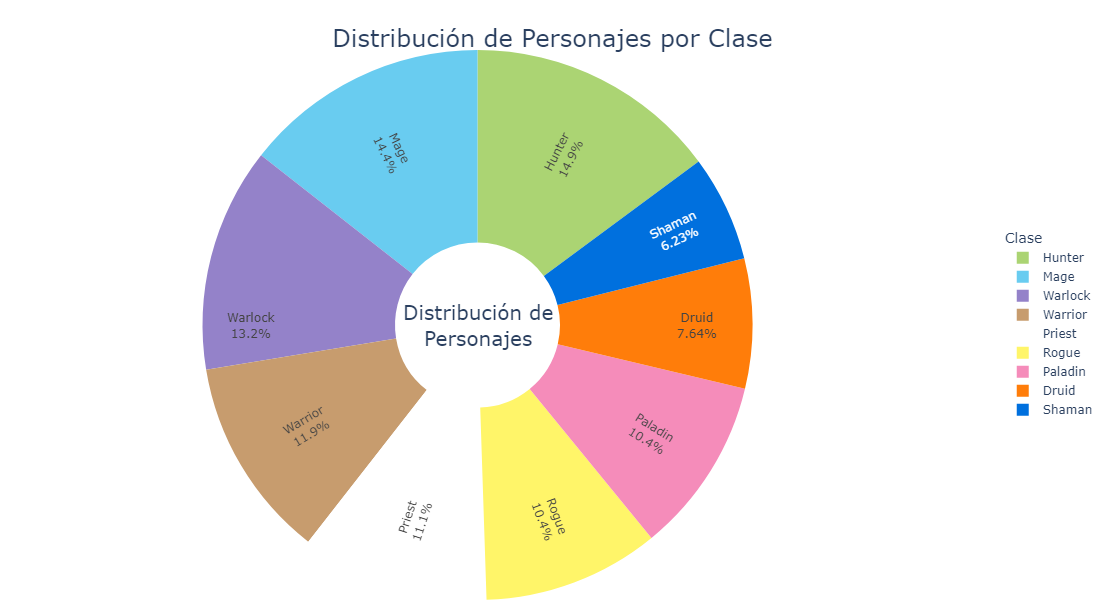

In [225]:
class_counts = wowah_data['charclass'].value_counts()


colors = {
    'Druid': '#FF7D0A',   # Naranja
    'Hunter': '#ABD473',  # Verde
    'Mage': '#69CCF0',    # Azul claro
    'Paladin': '#F58CBA', # Rosa
    'Priest': '#FFFFFF',  # Blanco
    'Rogue': '#FFF569',   # Amarillo
    'Shaman': '#0070DE',  # Azul
    'Warlock': '#9482C9', # Morado
    'Warrior': '#C79C6E'  # Marrón claro
}

fig = go.Figure(data=[go.Pie(
    labels=class_counts.index,
    values=class_counts,
    marker=dict(
        colors=[colors.get(clase, '#000000') for clase in class_counts.index]
    ),
    textinfo='label+percent',
    insidetextorientation='radial',
    hole=0.3 
)])

fig.update_layout(
    title_text='Distribución de Personajes por Clase',
    title_font_size=24,
    title_x=0.5,
    title_y=0.95,
    legend_title_text='Clase',
    legend=dict(
        x=1.05,  
        y=0.5,
        traceorder='normal',
        orientation='v'
    ),
    margin=dict(l=0, r=150, t=50, b=0),  
    width=800,  
    height=600,  
    annotations=[dict(
        text='Distribución de<br>Personajes',
        x=0.5,
        y=0.5,
        font_size=20,
        showarrow=False
    )]
)

fig.show()

Este análisis identifica las clases más jugadas en World of Warcraft mediante el conteo de personajes por clase. Utilizamos la función `value_counts()` para obtener la distribución de clases y asignamos colores específicos a cada una para mejorar la visualización. Luego, se crea un gráfico de pie con Plotly, que permite ver claramente las proporciones de cada clase. Este análisis nos ayuda a comprender las preferencias de los jugadores y la distribución de personajes en el juego.

In [226]:
class_counts = wowah_data['charclass'].value_counts()
class_counts


charclass
Hunter     155891
Mage       151202
Warlock    138181
Warrior    124262
Priest     116138
Rogue      108818
Paladin    108734
Druid       80061
Shaman      65288
Name: count, dtype: int64

Ya que el enfoque principal de nuestro analisis se basa nada mas en las dos primeras versiones del juego debido a la imnensa cantidad de datos nos gustaria dividir los numeros de jugadores totales asi que filtraremos solamente a la poblacion que jugo esas versiones de juego.

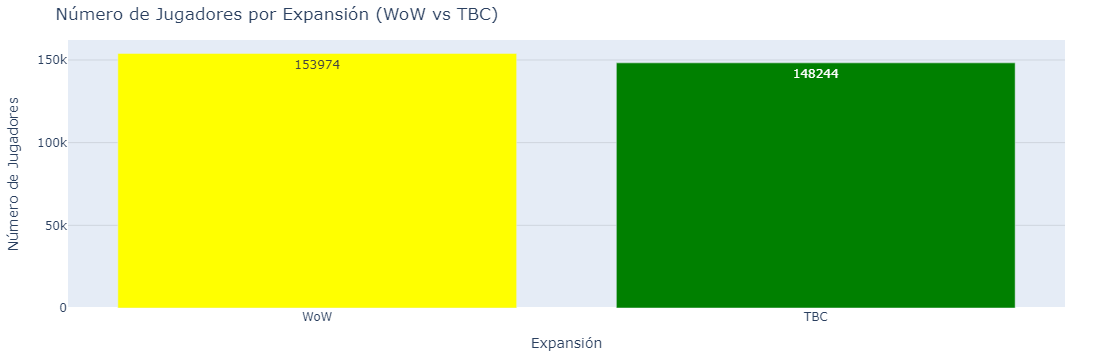

In [227]:
filtered_locations_wow = locations[locations['Game_Version'] == 'WoW']
filtered_locations_tbc = locations[locations['Game_Version'] == 'TBC']

filtered_wowah_data_wow = wowah_data[wowah_data['zone'].isin(filtered_locations_wow['Location_Name'])]
filtered_wowah_data_tbc = wowah_data[wowah_data['zone'].isin(filtered_locations_tbc['Location_Name'])]

merged_filtered_data_wow = pd.merge(filtered_wowah_data_wow, filtered_locations_wow, left_on='zone', right_on='Location_Name', how='left')
merged_filtered_data_tbc = pd.merge(filtered_wowah_data_tbc, filtered_locations_tbc, left_on='zone', right_on='Location_Name', how='left')

expansion_counts = {
    'WoW': len(merged_filtered_data_wow),
    'TBC': len(merged_filtered_data_tbc)
}

fig = go.Figure(data=[go.Bar(
    x=list(expansion_counts.keys()),
    y=list(expansion_counts.values()),
    marker_color=['yellow', 'green'],  
    text=[f'{count}' for count in expansion_counts.values()],
    textposition='auto'
)])

fig.update_layout(
    title='Número de Jugadores por Expansión (WoW vs TBC)',
    xaxis_title='Expansión',
    yaxis_title='Número de Jugadores',
    xaxis=dict(tickvals=[0, 1], ticktext=['WoW', 'TBC']),
    yaxis=dict(showgrid=True, gridcolor='rgba(0,0,0,0.1)', gridwidth=1),
    margin=dict(l=40, r=40, t=40, b=40)
)

fig.show()

Filtramos los datos de ubicaciones según las versiones del juego: World of Warcraft (WoW) y The Burning Crusade (TBC). Luego, utilizamos estos filtros para crear dos conjuntos de datos: uno para las zonas de WoW y otro para TBC, manteniendo solo las zonas relevantes para cada expansión.
A continuación, realizamos un *merge* entre los datos de personajes y las ubicaciones filtradas para obtener información sobre el número de jugadores por expansión. Finalmente, se genera un gráfico de barras que muestra la cantidad de jugadores en cada expansión, facilitando la comparación visual entre WoW y TBC. Este análisis nos permite evaluar la distribución de la base de jugadores a través de las diferentes expansiones del juego.

Para la exploracion de datos nos gustaria igualmente analizar el numero de jugadores por zona para asi tener una idea de como va a ser nuestra hipotesis principalmente.

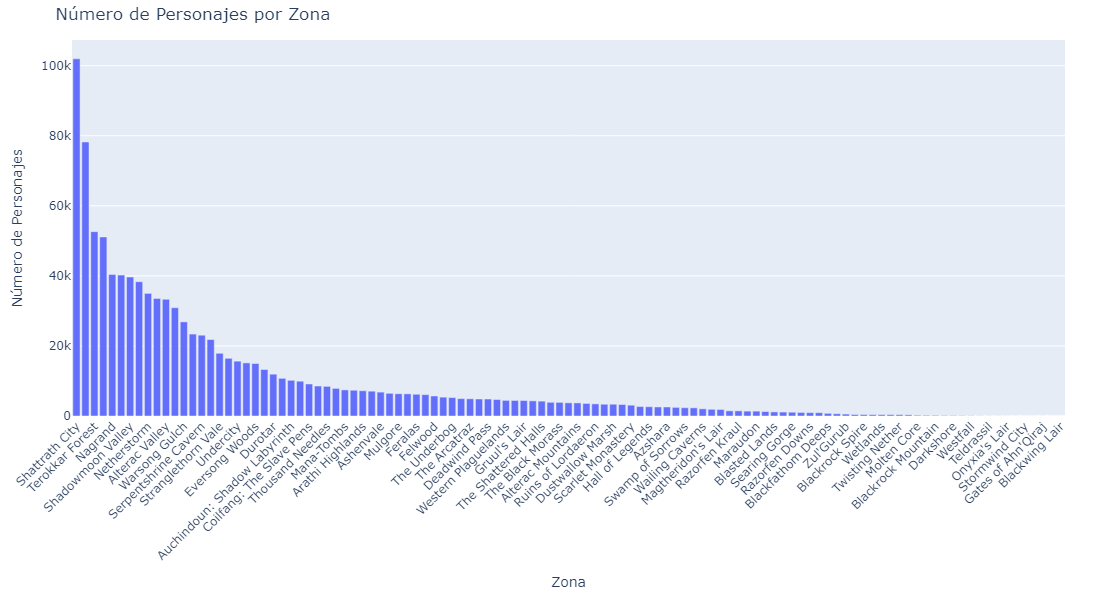

In [228]:
zone_counts = wowah_data['zone'].value_counts().reset_index()
zone_counts.columns = ['zone', 'count']

fig = px.bar(
    zone_counts,
    x='zone',
    y='count',
    title='Número de Personajes por Zona',
    labels={'zone': 'Zona', 'count': 'Número de Personajes'},
    height=600,
    width=1000
)

fig.update_layout(
    xaxis_title='Zona',
    yaxis_title='Número de Personajes',
    xaxis=dict(tickangle=-45), 
    margin=dict(l=40, r=40, t=40, b=100)  
)

fig.show()

Contamos el número de personajes en cada zona utilizando la función `value_counts()` de pandas, que nos proporciona una tabla con el conteo de personajes por zona. A continuación, se crea un gráfico de barras para visualizar la distribución de personajes en cada zona del juego.

este gráfico proporciona una visión general útil para entender cómo se distribuyen los jugadores en diferentes zonas y puede servir como base para explorar más a fondo las razones detrás de estas tendencias.

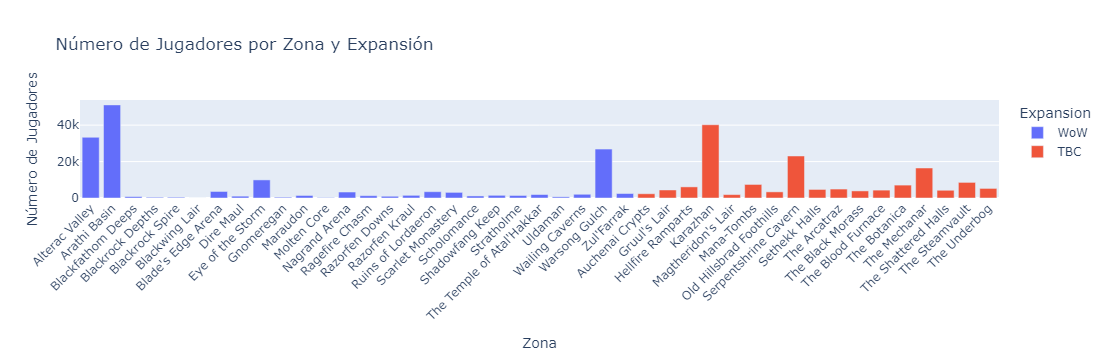

In [229]:

filtered_wowah_data_wow = wowah_data[wowah_data['zone'].isin(locations[locations['Game_Version'] == 'WoW']['Location_Name'])]
filtered_wowah_data_tbc = wowah_data[wowah_data['zone'].isin(locations[locations['Game_Version'] == 'TBC']['Location_Name'])]


expansion_zone_counts = pd.concat([
    filtered_wowah_data_wow.assign(Expansion='WoW'),
    filtered_wowah_data_tbc.assign(Expansion='TBC')
])

zone_expansion_counts = expansion_zone_counts.groupby(['zone', 'Expansion']).size().reset_index(name='count')

fig = px.bar(zone_expansion_counts, x='zone', y='count', color='Expansion',
             title='Número de Jugadores por Zona y Expansión',
             labels={'zone': 'Zona', 'count': 'Número de Jugadores'})
fig.update_layout(xaxis_title='Zona', yaxis_title='Número de Jugadores', xaxis_tickangle=-45)
fig.show()

Filtramos los datos de personajes en función de las expansiones "WoW" y "TBC", utilizando la función `isin()` para seleccionar solo las zonas correspondientes a cada expansión. Luego, concatenamos los datos filtrados y contamos el número de jugadores por zona y expansión mediante la función `groupby()`.

El gráfico de barras que presentamos muestra la distribución del número de jugadores en las distintas zonas, diferenciadas por expansión. Este análisis nos permite comparar la popularidad de las zonas entre WoW y TBC, proporcionando información sobre cómo la población de jugadores varía en función de la expansión y ayudando a entender las preferencias de los jugadores en diferentes versiones del juego.

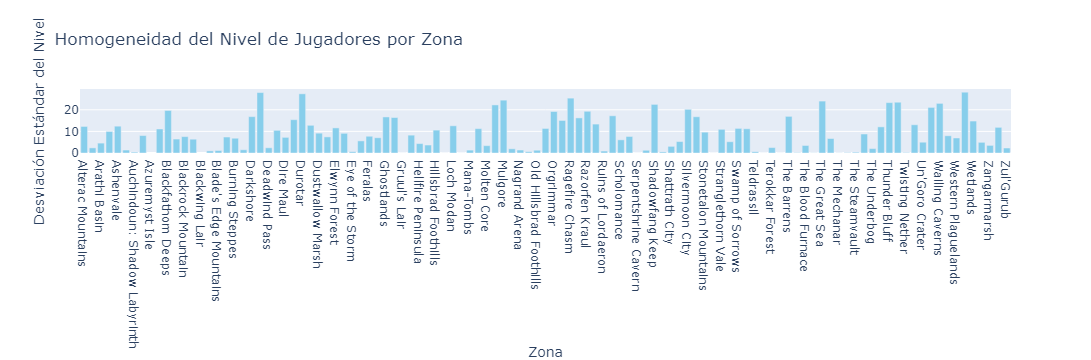

In [230]:
std_dev_by_zone = wowah_data.groupby('zone')['level'].std().reset_index()

fig = go.Figure(data=[go.Bar(x=std_dev_by_zone['zone'], y=std_dev_by_zone['level'], 
                             marker_color='skyblue')])
fig.update_layout(
    title='Homogeneidad del Nivel de Jugadores por Zona',
    xaxis_title='Zona',
    yaxis_title='Desviación Estándar del Nivel'
)
fig.show()

Calculamos la desviación estándar del nivel de los jugadores en cada zona utilizando la función `groupby()` de pandas. Esta medida nos permite evaluar la variabilidad del nivel de los personajes dentro de cada área.

El gráfico de barras que presentamos muestra la desviación estándar de los niveles de los jugadores en cada zona. Este análisis nos permite ver cuán homogéneos o variados son los niveles de los jugadores en diferentes zonas. Las zonas con una baja desviación estándar tienen niveles más uniformes, mientras que aquellas con una alta desviación estándar muestran una mayor diversidad de niveles. Esto nos ayuda a entender mejor la distribución de los niveles en el juego y cómo varía la experiencia de los jugadores según la zona.

A continuacion utilizaremos una matriz de correlación para explorar la relación entre el nivel de los personajes y las características de las zonas en World of Warcraft. Al combinar datos sobre el nivel de los jugadores y las propiedades de las zonas, como los niveles mínimo requerido, recomendado y máximo, así como los niveles de los bots, podemos identificar patrones que influyen en la jugabilidad.
La integración de la matriz de correlación es fundamental para tomar decisiones informadas sobre el equilibrio del juego y la accesibilidad de las zonas, asegurando que se alineen con las expectativas y comportamientos de los jugadores.

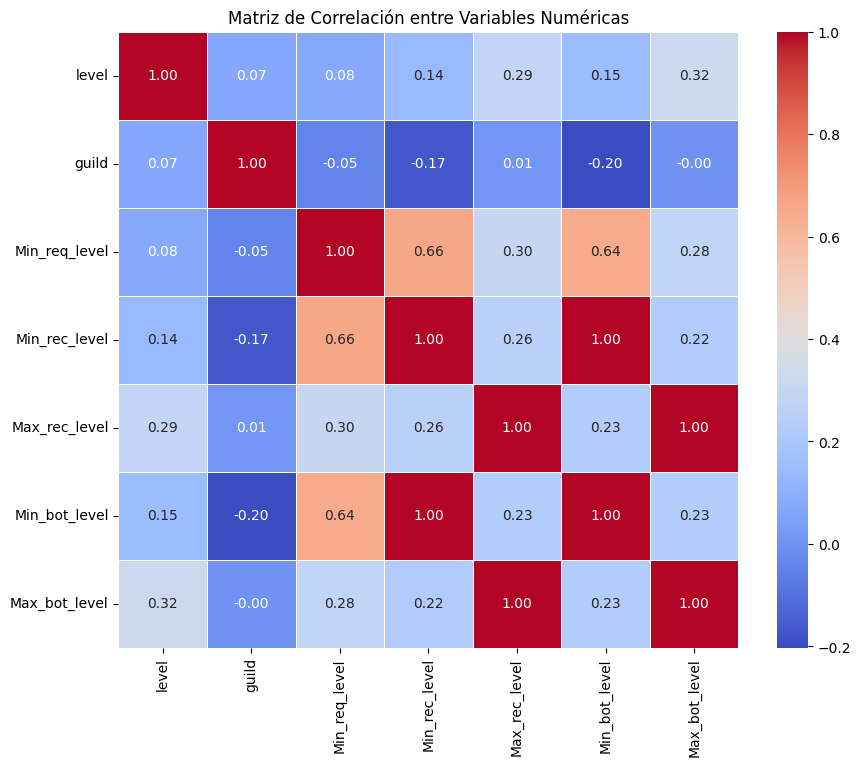

In [231]:
data_combined = pd.concat([wowah_data[['level', 'guild']], 
                           zones[['Min_req_level', 'Min_rec_level', 'Max_rec_level', 'Min_bot_level', 'Max_bot_level']]], 
                          axis=1)

correlation_matrix = data_combined.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

Al observar la matriz de correlación, podemos identificar relaciones clave entre variables numéricas importantes, como los niveles de los jugadores y las zonas en las que se encuentran. Por ejemplo, una correlación moderada entre el nivel de los personajes y el nivel máximo recomendado de la zona podría indicar que los jugadores tienden a seguir las recomendaciones del juego en cuanto a dónde deberían estar. Por otro lado, correlaciones más bajas en otras áreas podrían sugerir que algunos jugadores se aventuran en zonas fuera de su nivel recomendado, lo que refleja una mayor flexibilidad en el estilo de juego y exploración del mundo.

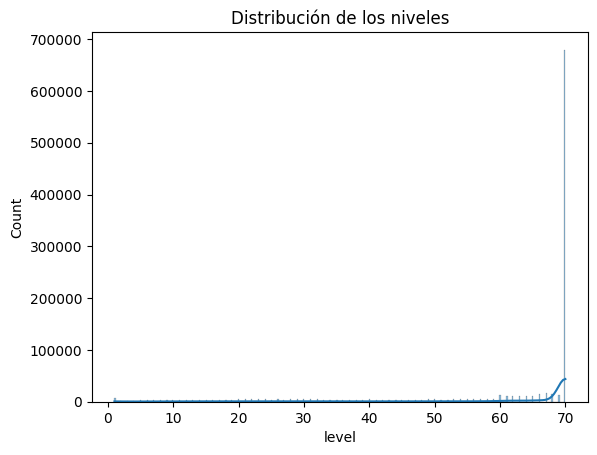

In [232]:
sns.histplot(wowah_data['level'], kde=True)
plt.title('Distribución de los niveles')
plt.show()

En este gráfico, utilizamos un histograma combinado con una estimación de densidad (KDE) para visualizar la distribución de los niveles de los personajes en World of Warcraft. El histograma nos proporciona una representación clara de la frecuencia de cada nivel, mientras que la curva de KDE suaviza la distribución, ayudando a identificar patrones y tendencias en los datos.

FASE 3 : Preparación de los datos

Ahora procederemos a configurar y perfeccionar los DataSet para nuestra conveniencia y así llegar a la solución con datos limpios y significativos.

In [233]:
wowah_data['timestamp'] = pd.to_datetime(wowah_data['timestamp'], format='%m/%d/%y %H:%M:%S')

wowah_data['timestamp'] = wowah_data['timestamp'].astype('int64') // 10**9

wowah_data['timestamp'].head()


0    1199145724
1    1199145724
2    1199145724
3    1199145724
4    1199145729
Name: timestamp, dtype: int64

Cambiamos el tipo de dato de TIMESTAMP de wowah_data para trabajar con numeros y no con tipos de datos de fecha

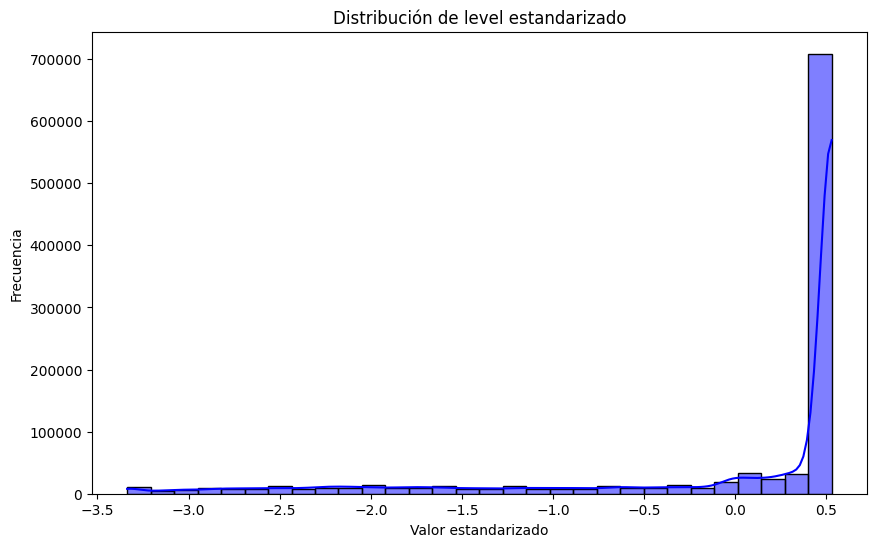

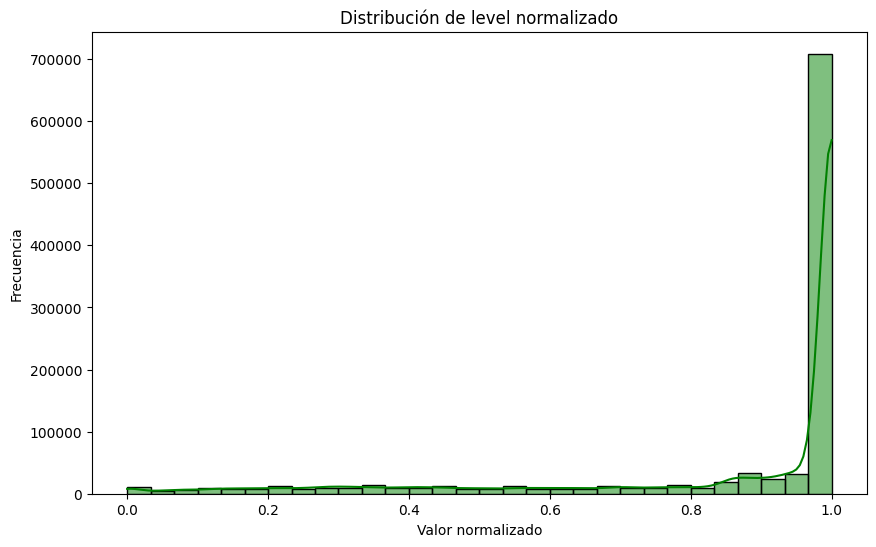

In [234]:
scaler = StandardScaler()
wowah_data_standardized = scaler.fit_transform(wowah_data[['level']])
normalizer = MinMaxScaler()
wowah_data_normalized = normalizer.fit_transform(wowah_data[['level']])


wowah_data_standardized_df = pd.DataFrame(wowah_data_standardized, columns=['level_standardized'])
wowah_data_normalized_df = pd.DataFrame(wowah_data_normalized, columns=['level_normalized'])

plt.figure(figsize=(10, 6))
sns.histplot(wowah_data_standardized_df['level_standardized'], kde=True, color='blue', bins=30)
plt.title('Distribución de level estandarizado')
plt.xlabel('Valor estandarizado')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(wowah_data_normalized_df['level_normalized'], kde=True, color='green', bins=30)
plt.title('Distribución de level normalizado')
plt.xlabel('Valor normalizado')
plt.ylabel('Frecuencia')
plt.show()

Primero, utilizamos StandardScaler para transformar los datos a una distribución con media 0 y desviación estándar 1. Luego, aplicamos MinMaxScaler para ajustar los valores al rango de 0 a 1. Los resultados se convierten en DataFrames para facilitar la visualización. Finalmente, se generan histogramas con seaborn para mostrar las distribuciones de los datos estandarizados y normalizados, permitiendo comparar cómo se distribuyen los niveles de los jugadores tras cada transformación.

[09/30/24 01:41:25] WARNING  C:\Users\Juanjo\Documents\wow\machinwow\Lib\site-packages\sklearn\base warnings.py:110
                             .py:493: UserWarning:                                                                 
                                                                                                                   
                             X does not have valid feature names, but PolynomialFeatures was fitted                
                             with feature names                                                                    
                                                                                                                   
                                                                                                                   

[09/30/24 01:41:27] WARNING  C:\Users\Juanjo\Documents\wow\machinwow\Lib\site-packages\IPython\core warnings.py:110
                             \pylabtools.py:170: UserWarning:                                                      
                                                                                                                   
                             Creating legend with loc="best" can be slow with large amounts of                     
                             data.                                                                                 
                                                                                                                   
                                                                                                                   

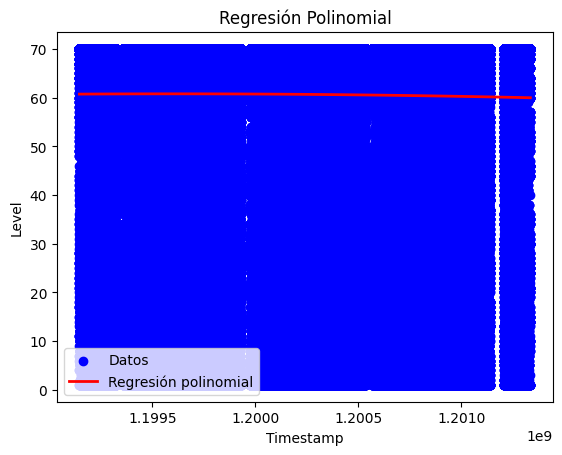

In [235]:
# Selecciona la característica y el objetivo
X = wowah_data[['timestamp']]
y = wowah_data['level']

degree = 3  
model = make_pipeline(
  PolynomialFeatures(degree=degree, include_bias=False),
  LinearRegression()
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)


X_plot = np.linspace(X['timestamp'].min(), X['timestamp'].max(), 100).reshape(-1, 1)
y_plot = model.predict(X_plot)


plt.scatter(X, y, color='blue', label='Datos')
plt.plot(X_plot, y_plot, color='red', linewidth=2, label='Regresión polinomial')
plt.xlabel('Timestamp')
plt.ylabel('Level')
plt.title('Regresión Polinomial')
plt.legend()
plt.show()

Se realizó una regresión polinomial para modelar la relación entre el timestamp y el nivel de los personajes en World of Warcraft. Se seleccionó `timestamp` como característica independiente y `level` como variable objetivo. Se creó un modelo utilizando un pipeline que incluye características polinomiales de grado 3 y regresión lineal. Los datos se dividieron en conjuntos de entrenamiento y prueba, y el modelo se entrenó con los datos de entrenamiento. Luego, se generaron predicciones sobre un rango de timestamps para visualización. En la gráfica, los puntos azules representan los datos reales y la línea roja muestra la predicción del modelo, ayudando a entender cómo varía el nivel de los personajes con el tiempo.

In [236]:
numeric_columns = zones.select_dtypes(include=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)

zones[numeric_columns] = imputer.fit_transform(zones[numeric_columns])

print(zones.isnull().sum())

Zone_Name          0
Continent          0
Area               3
Zone               7
Subzone          108
Type               0
Size               0
Controlled         0
Min_req_level      0
Min_rec_level      0
Max_rec_level      0
Min_bot_level      0
Max_bot_level      0
dtype: int64


Se seleccionaron las columnas numéricas del DataFrame `zones` para preparar la imputación de valores faltantes. Se utilizó el `KNNImputer`.
Tras aplicar la imputación, se verificaron los datos faltantes en el DataFrame, mostrando cuántos valores faltantes permanecen en cada columna. Esto asegura que los datos estén completos para un análisis más preciso y significativo.

In [237]:
diccionario = {'Subzone':'None','Area':'None','Zone':'None', }
zones = zones.fillna(diccionario)

Se creó un diccionario para rellenar los valores faltantes en las columnas del DataFrame `zones` con el valor 'None'. Esto permite que estas columnas mantengan consistencia en los datos al evitar que contengan valores nulos, facilitando así el análisis posterior.

In [238]:
zones.isnull().sum()


Zone_Name        0
Continent        0
Area             0
Zone             0
Subzone          0
Type             0
Size             0
Controlled       0
Min_req_level    0
Min_rec_level    0
Max_rec_level    0
Min_bot_level    0
Max_bot_level    0
dtype: int64

Se utiliza `zones.isnull().sum()` para contar el número de valores nulos en cada columna Esto es fundamental para identificar columnas con datos faltantes y determinar si se requieren estrategias adicionales de imputación o limpieza, Rellenamos los valores nulos del archivo zones, ya sea, colocando None a strings vacíos o ceros a valores numericos nulos.

In [239]:
zones['Min_rec_level'] = zones['Min_rec_level'].astype(int)
zones['Max_rec_level'] = zones['Max_rec_level'].astype(int)
zones['Min_bot_level'] = zones['Min_bot_level'].astype(int)
zones['Max_bot_level'] = zones['Max_bot_level'].astype(int)

Ahora normalizamos los numeros del archivos zones a tipo de dato entero (`int`), Estom es importante para que podamos trabajar de mejor manera con columnas del mismo tipo de dato.

In [240]:
wowah_data['guild'] = wowah_data['guild'].replace(-1, 0)

###### Después normalizamos los numeros del archivos wowah_data, cambiando los numeros -1 a 0's.

In [241]:
wowah_data.columns = wowah_data.columns.str.strip()

Quitamos los espacios de las columnas del dataset para poder referirnos correctamente a las columnas que necesitemos.

In [242]:
z = np.abs(stats.zscore(wowah_data['level']))
wowah_data = wowah_data[( z < 3 )]
wowah_data

,char,level,race,charclass,zone,guild,timestamp
1,65494,9,Orc,Hunter,Durotar,0,1199145724
2,65325,14,Orc,Warrior,Ghostlands,0,1199145724
3,65490,18,Orc,Hunter,Ghostlands,0,1199145724
4,2288,60,Orc,Hunter,Hellfire Peninsula,0,1199145729
5,2289,60,Orc,Hunter,Hellfire Peninsula,0,1199145729
...,...,...,...,...,...,...,...
1048570,1094,70,Undead,Rogue,Arathi Basin,103,1201335118
1048571,22703,70,Undead,Warlock,Orgrimmar,103,1201335123
1048572,33016,70,Undead,Warlock,Orgrimmar,204,1201335123
1048573,8245,70,Undead,Warlock,Shadowmoon Valley,19,1201335123


Recortamos los outliers de wowah_data con niveles menores a 3 de la columna de level, puesto que queremos dejar lo mas representativo

Ahora procedemo a recortar los datos aun mas, sacamos los outliers de los DataFrames ( wowah_data y zones ) con la puntuación IQR y comparamos con el antes y los nuevos datos mas significativos.

In [243]:
wowah_data_antes = wowah_data
wowah_data_antes.shape

(1026942, 7)

In [244]:
Q1 = wowah_data['level'].quantile(0.25)
Q3 = wowah_data['level'].quantile(0.75)
IQR = Q3 - Q1
wowah_data = wowah_data[~((wowah_data['level'] < (Q1 - 1.5 * IQR ))|(wowah_data['level'] > (Q3 + 1.5 * IQR )))]
wowah_data.shape

(842445, 7)

In [245]:
zones_antes = zones
zones_antes.shape

(160, 13)

In [246]:
Q1 = zones['Min_rec_level'].quantile(0.25)
Q3 = zones['Min_rec_level'].quantile(0.75)
IQR = Q3 - Q1
zones = zones[~((zones['Min_rec_level'] < (Q1 - 1.5 * IQR ))|(zones['Min_rec_level'] > (Q3 + 1.5 * IQR )))]
zones.shape


(160, 13)

Primero, hacemos una copia de wowah_data para poder ver el antes y después del tamaño de los datos. Aplicamos la puntuación IQR para sacar de nuestra ecuacion aquellos datos que estan fuera de nuestros cuartiles principales. Y luego hacemos lo mismo con zones.

In [5]:
wowah_lasso = wowah_data2


wowah_lasso.drop(columns=['char', 'timestamp'], inplace=True)


encoder = OneHotEncoder(drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(wowah_lasso[['race', 'charclass', 'zone']]).toarray())


wowah_lasso = wowah_lasso.join(encoded_df)
wowah_lasso.drop(columns=['race', 'charclass', 'zone'], inplace=True)


X = wowah_lasso.drop(columns='level')
y = wowah_lasso['level']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lasso = Lasso(alpha=0.1)
X.columns = X.columns.astype(str)


X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


lasso.fit(X_train, y_train)


y_pred = lasso.predict(X_test)


mse_corrected = mean_squared_error(y_test, y_pred)
mae_corrected = mean_absolute_error(y_test, y_pred)

lasso.coef_, mse_corrected, mae_corrected


(
    array([ 6.04506708e-03,  1.23183587e+00,  1.90256054e+00,  1.21128170e+00,
        3.64429686e+00, -0.00000000e+00,  5.34762413e-01, -2.56584810e-01,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.93041225e-02,  4.78384298e+00,  5.56400265e+00, -5.90663348e+00,
       -1.30113510e+01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.22984170e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -2.76083640e+01, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -4.29098359e+01,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -2.99955309e+01, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000

Por ultimo, hacemos una copia de WOWAH_DATA para poder ejecutar algunas pruebas sobre modelaje, en este caso el modelo de regresión lasso el cual nos brinda mejoras en la visualizacion de predicciones futuras e interpretaciones de modelos lineales. Para este codigo eliminamos las columnas innecesarias para el modelo, convertimos las variables categoricas en binarias, hacemos nuestros conjuntos de pruebas y entrenamiento, entrenamos el modelo para después tener nuestro resultado de prediccion, cálculo de error cuadratico medio (MSE) y el error absoluto medio (MAE), donde un MSE más bajo indica un mejor ajuste del modelo a los datos.

Todo esto de la limpieza y pulido de datos serán para que no puedan dar errores a la hora de llegar a la fase de modelar y tambien para que los resultados estén acordes a los datos mas representativos de nuestros DataSet.